In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import lmfit as lm
import pandas as pd

In [5]:
instability = pd.read_csv("Instability.csv")
instability[:5]

,Unnamed: 0,Age,Instability Mean,Instability Std
0,0,18,0.245675,0.034125
1,1,19,0.218225,0.017177
2,2,20,0.246581,0.034939
3,3,21,0.199794,0.000000
4,4,22,0.234449,0.025944


In [6]:
instability_clean = instability[instability["Instability Std"]>0]

<Container object of 3 artists>

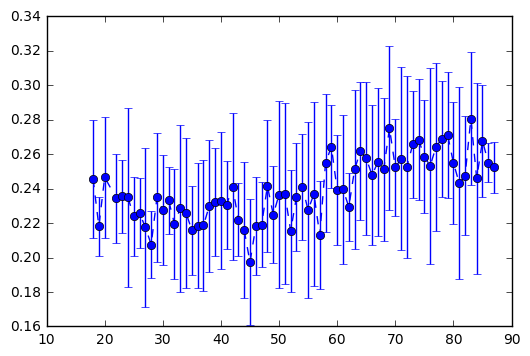

In [10]:
plt.errorbar(instability_clean["Age"],
             instability_clean["Instability Mean"],
             yerr=instability_clean["Instability Std"],
             fmt="--o")

In [30]:
def sigmoid(x,off,ampl,switchpoint,width):
    return off + ampl/(1+np.exp(-(x-switchpoint)/width))

In [32]:
sigmoid_Model = lm.Model(sigmoid)
pars = sigmoid_Model.make_params()
pars['off'].set(value=instability_clean["Instability Mean"].min(),vary=True)
pars['ampl'].set(value=instability_clean["Instability Mean"].max()-instability_clean["Instability Mean"].min(),vary=True)
pars['switchpoint'].set(value=50,vary=True)
pars['width'].set(value=.1,vary=True)

out = sigmoid_Model.fit(instability_clean["Instability Mean"], pars, x=instability_clean["Age"], weights=1/instability_clean["Instability Std"])
print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(sigmoid)
[[Fit Statistics]]
    # function evals   = 306
    # data points      = 69
    # variables        = 4
    chi-square         = 8.375
    reduced chi-square = 0.129
    Akaike info crit   = -133.390
    Bayesian info crit = -124.454
[[Variables]]
    off:           0.22502909 +/- 0.001963 (0.87%) (init= 0.1973084)
    ampl:          0.03256457 +/- 0.003320 (10.20%) (init= 0.08328854)
    switchpoint:   59.5584540 +/- 1.999813 (3.36%) (init= 50)
    width:         3.80748981 +/- 1.956170 (51.38%) (init= 0.1)
[[Correlations]] (unreported correlations are <  0.250)
    C(off, ampl)                 = -0.658 
    C(ampl, width)               =  0.481 
    C(off, width)                = -0.352 
    C(off, switchpoint)          =  0.300 



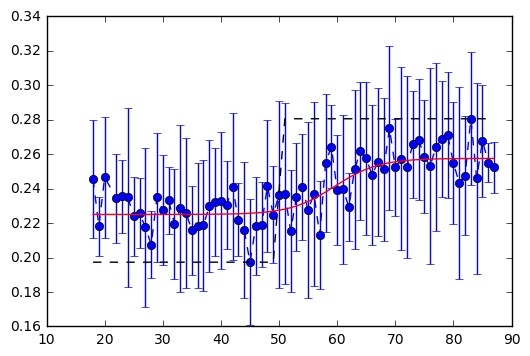

In [33]:
plt.errorbar(instability_clean["Age"],
             instability_clean["Instability Mean"],
             yerr=instability_clean["Instability Std"],
             fmt="--o")
#plt.plot(instability_clean["Age"], out.init_fit, 'k--')
plt.plot(instability_clean["Age"], out.best_fit, 'r-')
